# MAE 598 Project 1

### Code

In [18]:
# overhead

# import math
import random
import numpy as np
import time
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import logging

logger = logging.getLogger(__name__)

In [19]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [20]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        state:
        state[0] = x
        state[1] = y
        state[2] = x_dot
        state[3] = y_dot
        state[4] = theta
        
        action:
        action[0]: thrust
        action[1]: step angle
        """

        # State change in the next time step
        # state = t.tensor(state).float()
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0.],
                             [0., 1., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0.],
                             [0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 1.]])
        state1 = t.matmul(state, step_mat)
        
        # Apply thrust and angular control
        delta_state_1 = BOOST_ACCEL * FRAME_TIME * -0.5 * (FRAME_TIME ** 2) * t.sin(state[:, 4].reshape(-1, 1))
        delta_state_2 = BOOST_ACCEL * FRAME_TIME * -0.5 * (FRAME_TIME ** 2) * t.cos(state[:, 4].reshape(-1, 1))
        delta_state_3 = BOOST_ACCEL * FRAME_TIME * -FRAME_TIME * t.sin(state[:, 4].reshape(-1, 1))
        delta_state_4 = BOOST_ACCEL * FRAME_TIME * FRAME_TIME * t.cos(state[:, 4].reshape(-1, 1))

        zeros_col = t.zeros(len(state[:, 4]), 1)
        ones_col = t.ones(len(state[:, 4]), 1)

        delta_state_mat1 = t.cat((delta_state_1, delta_state_2, delta_state_3, delta_state_4, zeros_col), dim=1)
        delta_state_mat2 = t.cat((t.zeros(len(state[:, 4]), dim_input-1), ones_col), dim=1)

        delta_state_alpha = t.mul(action[:, 0].reshape(-1, 1), delta_state_mat1)
        delta_state_theta = t.mul(action[:, 1].reshape(-1, 1), delta_state_mat2)
        
        # Apply gravity
        delta_state_g = t.tensor([0., -0.5 * GRAVITY_ACCEL * (FRAME_TIME ** 2), 0., 0., 0.])
        delta_state_gravity = t.mul(t.ones(len(state[:, 4]), 1), delta_state_g)
        
        # Update state
        state_next = state + delta_state_alpha + delta_state_theta + delta_state_gravity

        return state_next
    
t.autograd.set_detect_anomaly(True)

In [21]:
# Deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            # nn.Linear(dim_hidden, dim_hidden),
            # nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),         
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        # print('state:', state)
        # print(action)
        return action

In [22]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        batch_sz = 4
        bounds = np.array([[-1, 1], [0, 10], [0, 5], [0, 5], [0, 90]])
        state = np.random.uniform(bounds[:, 0], bounds[:, 1], (batch_sz, bounds.shape[0]))
        # state = state.reshape(state.shape[0], state.shape[1], 1)
        # state = [1., 0., 0., 0., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        error = t.sum(state[:, 0]**2 + state[:, 1]**2 + state[:, 2]**2 + state[:, 3]**2 + state[:, 4]**2)
        return error.mean()

In [23]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            data = self.visualize()
        return data

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print(data.shape)
        x = data[:, 2, 0]
        y = data[:, 2, 1]
        plt.plot(x, y)
        plt.show()
        return data

[1] loss: 39380.109
(100, 4, 5)


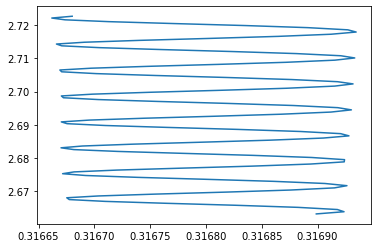

In [24]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
data = o.train(1)  # solve the optimization problem

In [26]:
data.shape

(100, 4, 5)

In [28]:
data[:, 0, 0].shape

(100,)

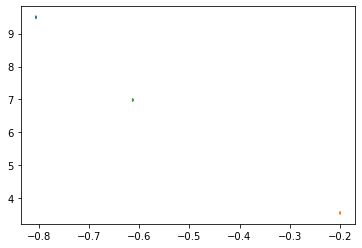

In [33]:
plt.plot(data[:, 3, 0], data[:, 3, 1])
plt.plot(data[:, 0, 0], data[:, 0, 1])
plt.plot(data[:, 1, 0], data[:, 1, 1])